## 全连接神经网络建模实现
### 使用多层神经元进行模型构建  

<img style="float:left;zoom:60%" src="pic/more.png">本次将使用四隐藏层神经元进行模型构建，每层神经元个数为 256、128、64、32，其中我们将首次引入 dropout 层来防止多层神经元带来的过拟合问题，dropout 层是通过随机放弃部分神经元参与模型训练，让每次神经元之间的连接不同，关于具体的 drop out层将在博客中详细讲解<br><br><br>采用的激活函数仍是 softmax<br><br><br>$output = f(z) = f(\sum_{i=1}^nx_i*w_i+b)$ 

### 导入必要模块

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import math
import matplotlib.pyplot as plt
import time
import os


mnist = input_data.read_data_sets('./mnist_dataset/', one_hot=True)

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist_dataset/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist_dataset/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./mnist_dataset/t10k-images-idx3-ubyte.gz
Extracting ./mnist_dataset/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


### 构建输入层

In [2]:
x = tf.placeholder(tf.float32, [None, 784], name='X')
y = tf.placeholder(tf.float32, [None, 10], name='Y')

### 第 1 ~ 4 隐藏层
注意，多层神经网络中，生成权值不适用完全随机数，使用截断的方法 tf.truncated_normal() 生成随机数，否则容易造成 Loss = Nan 情况

In [3]:
H1_NN = 256

W1 = tf.Variable(tf.truncated_normal([784, H1_NN], stddev=0.1))
b1 = tf.Variable(tf.zeros([H1_NN]))

Y1 = tf.nn.relu(tf.matmul(x, W1) + b1)
Y1 = tf.nn.dropout(Y1, rate=0.2)

In [4]:
H2_NN = 128

W2 = tf.Variable(tf.truncated_normal([H1_NN, H2_NN], stddev=0.1))
b2 = tf.Variable(tf.zeros([H2_NN]))

Y2 = tf.nn.relu(tf.matmul(Y1, W2) + b2)
Y2 = tf.nn.dropout(Y2, rate=0.2)

In [5]:
H3_NN = 64

W3 = tf.Variable(tf.truncated_normal([H2_NN, H3_NN], stddev=0.1))
b3 = tf.Variable(tf.zeros([H3_NN]))

Y3 = tf.nn.relu(tf.matmul(Y2, W3) + b3)
Y3 = tf.nn.dropout(Y3, rate=0.2)

In [6]:
H4_NN = 32

W4 = tf.Variable(tf.truncated_normal([H3_NN, H4_NN], stddev=0.1))
b4 = tf.Variable(tf.zeros([H4_NN]))

Y4 = tf.nn.relu(tf.matmul(Y3, W4) + b4)
Y4 = tf.nn.dropout(Y4, rate=0.2)

### 构建输出层

In [7]:
W_out = tf.Variable(tf.truncated_normal([H4_NN, 10], stddev=0.1))
b_out = tf.Variable(tf.zeros([10]))

forward = tf.matmul(Y4, W_out) + b_out
pred = tf.nn.softmax(forward)

### 定义损失函数
原始定义方式：<br>&ensp;&ensp;&ensp;&ensp;`loss_function = tf.reduce_mean(-tf.reduce_sum(y * tf.log(pred), reduction_indices=1))`  
为了避免&ensp;$\lim_{x\to0}log(x)$&ensp;造成值趋于无穷大，使得最终的 loss 值超出认可范围，将使用 TensorFlow 1.x 自带的 Softmax 交叉熵损失函数定义方法

In [8]:
loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=forward, labels=y))

### 设置训练参数

In [9]:
epochs = 150
batch_size = 100
total_batch = int(mnist.train.num_examples / batch_size)
display_step = 1
learning_rate = 0.01

### 选择优化器

In [10]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_function)

### 定义准确率

In [11]:
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### 开始训练

In [12]:
startTime = time.time()

sess = tf.Session()

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

sess.run(tf.global_variables_initializer())
for epoch in range(epochs):
    if epoch > 99:
        learning_rate = 0.001
    for batch in range(total_batch):
        xs, ys = mnist.train.next_batch(batch_size)
        sess.run(optimizer, feed_dict={x:xs, y:ys})
    train_loss, train_acc = sess.run([loss_function, accuracy],
                         feed_dict={x:mnist.train.images, y:mnist.train.labels})
    val_loss, val_acc = sess.run([loss_function, accuracy],
                         feed_dict={x:mnist.validation.images, y:mnist.validation.labels})
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    if (epoch + 1) % display_step == 0:
        print('Epoch: %3d' % (epoch + 1), 
              'train_loss=%6f' % train_loss, 
              'train_accuracy=%4f' % train_acc,
              'val_loss=%6f' % val_loss, 
              'val_accuracy=%4f' % val_acc,
              'learning_rate=%.4f' % learning_rate)

duration = time.time() - startTime
print('INFO:Train Finished!\nTaking for %d seconds!' % duration)

Epoch:   1 train_loss=1.922020 train_accuracy=0.378764 val_loss=1.915097 val_accuracy=0.383000 learning_rate=0.0100
Epoch:   2 train_loss=1.111546 train_accuracy=0.613345 val_loss=1.092543 val_accuracy=0.623600 learning_rate=0.0100
Epoch:   3 train_loss=0.857992 train_accuracy=0.712182 val_loss=0.827349 val_accuracy=0.722600 learning_rate=0.0100
Epoch:   4 train_loss=0.724654 train_accuracy=0.763800 val_loss=0.699354 val_accuracy=0.782800 learning_rate=0.0100
Epoch:   5 train_loss=0.635854 train_accuracy=0.798491 val_loss=0.623432 val_accuracy=0.808600 learning_rate=0.0100
Epoch:   6 train_loss=0.570143 train_accuracy=0.824236 val_loss=0.565459 val_accuracy=0.825800 learning_rate=0.0100
Epoch:   7 train_loss=0.525712 train_accuracy=0.838855 val_loss=0.509384 val_accuracy=0.846400 learning_rate=0.0100
Epoch:   8 train_loss=0.486234 train_accuracy=0.855655 val_loss=0.473201 val_accuracy=0.861800 learning_rate=0.0100
Epoch:   9 train_loss=0.447248 train_accuracy=0.866909 val_loss=0.455480

Epoch:  72 train_loss=0.110719 train_accuracy=0.968855 val_loss=0.143827 val_accuracy=0.962600 learning_rate=0.0100
Epoch:  73 train_loss=0.106527 train_accuracy=0.970436 val_loss=0.141202 val_accuracy=0.965400 learning_rate=0.0100
Epoch:  74 train_loss=0.108354 train_accuracy=0.969455 val_loss=0.146456 val_accuracy=0.961600 learning_rate=0.0100
Epoch:  75 train_loss=0.107008 train_accuracy=0.970073 val_loss=0.133718 val_accuracy=0.965600 learning_rate=0.0100
Epoch:  76 train_loss=0.105954 train_accuracy=0.969618 val_loss=0.134113 val_accuracy=0.964200 learning_rate=0.0100
Epoch:  77 train_loss=0.103651 train_accuracy=0.970964 val_loss=0.142134 val_accuracy=0.966400 learning_rate=0.0100
Epoch:  78 train_loss=0.101910 train_accuracy=0.971509 val_loss=0.150881 val_accuracy=0.962400 learning_rate=0.0100
Epoch:  79 train_loss=0.102776 train_accuracy=0.970691 val_loss=0.142525 val_accuracy=0.966400 learning_rate=0.0100
Epoch:  80 train_loss=0.100929 train_accuracy=0.971455 val_loss=0.137160

Epoch: 143 train_loss=0.053236 train_accuracy=0.984491 val_loss=0.120054 val_accuracy=0.971600 learning_rate=0.0010
Epoch: 144 train_loss=0.055174 train_accuracy=0.984273 val_loss=0.128828 val_accuracy=0.969400 learning_rate=0.0010
Epoch: 145 train_loss=0.051997 train_accuracy=0.985164 val_loss=0.128098 val_accuracy=0.970000 learning_rate=0.0010
Epoch: 146 train_loss=0.052802 train_accuracy=0.984127 val_loss=0.133567 val_accuracy=0.969400 learning_rate=0.0010
Epoch: 147 train_loss=0.052215 train_accuracy=0.984691 val_loss=0.131717 val_accuracy=0.970400 learning_rate=0.0010
Epoch: 148 train_loss=0.050656 train_accuracy=0.985600 val_loss=0.138663 val_accuracy=0.968600 learning_rate=0.0010
Epoch: 149 train_loss=0.051594 train_accuracy=0.985455 val_loss=0.130331 val_accuracy=0.967800 learning_rate=0.0010
Epoch: 150 train_loss=0.049943 train_accuracy=0.985691 val_loss=0.125346 val_accuracy=0.970800 learning_rate=0.0010
INFO:Train Finished!
Taking for 254 seconds!


In [13]:
test_acc = sess.run(accuracy, feed_dict={x:mnist.test.images, y:mnist.test.labels})
print('Test dataset accuracy: %f' % test_acc)

Test dataset accuracy: 0.969800


### 损失与准确率可视化

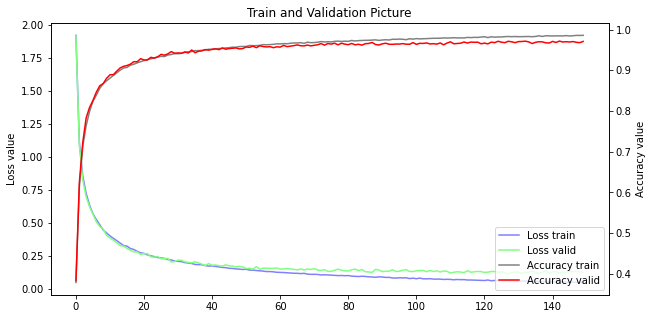

In [14]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
ax1 = fig.add_subplot(111)
ax1.set_title('Train and Validation Picture')
ax1.set_ylabel('Loss value')
line1, = ax1.plot(train_loss_list, color=(0.5, 0.5, 1.0), label='Loss train')
line2, = ax1.plot(val_loss_list, color=(0.5, 1.0, 0.5), label='Loss valid')
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy value')
line3, = ax2.plot(train_acc_list, color=(0.5, 0.5, 0.5), label='Accuracy train')
line4, = ax2.plot(val_acc_list, color=(1, 0, 0), label='Accuracy valid')
plt.legend(handles=(line1, line2, line3, line4), loc='best')
plt.show()

In [15]:
sess.close()

### 定义全连接函数简化网络定义代码并保存模型

In [16]:
def fcn_layer(inputs,
              input_dim,
              output_dim,
              activation=None):
    W = tf.Variable(tf.truncated_normal([input_dim, output_dim], stddev=0.1))
    b = tf.Variable(tf.zeros([output_dim]))
    XWb = tf.matmul(inputs, W) + b
    if activation is None:
        outputs = XWb
    else:
        outputs = activation(XWb)
        outputs = tf.nn.dropout(outputs, rate=0.2)
    
    return outputs

In [17]:
x = tf.placeholder(tf.float32, [None, 784], name='X')

h1 = fcn_layer(x, 784, 256, tf.nn.relu)
h2 = fcn_layer(h1, 256, 128, tf.nn.relu)
h3 = fcn_layer(h2, 128, 64, tf.nn.relu)
h4 = fcn_layer(h3, 64, 32, tf.nn.relu)

forward = fcn_layer(h4, 32, 10, None)
pred = tf.nn.softmax(forward)

In [18]:
epochs = 201
batch_size = 100
total_batch = int(mnist.train.num_examples / batch_size)
display_step = 1
learning_rate = 0.01
save_step = 5

ckpt_dir = './mnist_ckpt'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=forward, labels=y))

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_function)

correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [19]:
startTime = time.time()

saver = tf.train.Saver()
sess = tf.Session()

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

sess.run(tf.global_variables_initializer())
for epoch in range(epochs):
    if epoch > 99:
        learning_rate = 0.001
    for batch in range(total_batch):
        xs, ys = mnist.train.next_batch(batch_size)
        sess.run(optimizer, feed_dict={x:xs, y:ys})
    train_loss, train_acc = sess.run([loss_function, accuracy],
                         feed_dict={x:mnist.train.images, y:mnist.train.labels})
    val_loss, val_acc = sess.run([loss_function, accuracy],
                         feed_dict={x:mnist.validation.images, y:mnist.validation.labels})
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    if (epoch + 1) % display_step == 0:
        print('Epoch: %3d' % (epoch + 1), 
              'train_loss=%6f' % train_loss, 
              'train_accuracy=%4f' % train_acc,
              'val_loss=%6f' % val_loss, 
              'val_accuracy=%4f' % val_acc,
              'learning_rate=%.4f' % learning_rate)
    if (epoch + 1) % save_step == 0 or (epoch + 1) == epochs:
        saver.save(sess, os.path.join(ckpt_dir, 'mnist_model_{0:03d}.ckpt'.format(epoch + 1)))
        print('INFO:mnist_model_{0:03d}.ckpt saved'.format(epoch + 1))

duration = time.time() - startTime
print('INFO:Model saved\n', 'INFO:Train Finished!\nTaking for %d seconds!' % duration)

Epoch:   1 train_loss=2.021841 train_accuracy=0.281473 val_loss=2.032084 val_accuracy=0.273000 learning_rate=0.0100
Epoch:   2 train_loss=1.347954 train_accuracy=0.523127 val_loss=1.334656 val_accuracy=0.525200 learning_rate=0.0100
Epoch:   3 train_loss=0.962488 train_accuracy=0.674509 val_loss=0.936619 val_accuracy=0.687000 learning_rate=0.0100
Epoch:   4 train_loss=0.787442 train_accuracy=0.744200 val_loss=0.764963 val_accuracy=0.751000 learning_rate=0.0100
Epoch:   5 train_loss=0.678399 train_accuracy=0.785745 val_loss=0.660025 val_accuracy=0.798600 learning_rate=0.0100
INFO:mnist_model_005.ckpt saved
Epoch:   6 train_loss=0.609951 train_accuracy=0.810818 val_loss=0.588995 val_accuracy=0.821800 learning_rate=0.0100
Epoch:   7 train_loss=0.550840 train_accuracy=0.833709 val_loss=0.514423 val_accuracy=0.850200 learning_rate=0.0100
Epoch:   8 train_loss=0.510812 train_accuracy=0.846000 val_loss=0.494456 val_accuracy=0.858800 learning_rate=0.0100
Epoch:   9 train_loss=0.476533 train_acc

INFO:mnist_model_065.ckpt saved
Epoch:  66 train_loss=0.122726 train_accuracy=0.966127 val_loss=0.178846 val_accuracy=0.955600 learning_rate=0.0100
Epoch:  67 train_loss=0.121295 train_accuracy=0.966327 val_loss=0.154882 val_accuracy=0.961000 learning_rate=0.0100
Epoch:  68 train_loss=0.117183 train_accuracy=0.966127 val_loss=0.156866 val_accuracy=0.960600 learning_rate=0.0100
Epoch:  69 train_loss=0.116543 train_accuracy=0.968327 val_loss=0.154183 val_accuracy=0.961200 learning_rate=0.0100
Epoch:  70 train_loss=0.115000 train_accuracy=0.968582 val_loss=0.153154 val_accuracy=0.960600 learning_rate=0.0100
INFO:mnist_model_070.ckpt saved
Epoch:  71 train_loss=0.115551 train_accuracy=0.968000 val_loss=0.161871 val_accuracy=0.956400 learning_rate=0.0100
Epoch:  72 train_loss=0.113663 train_accuracy=0.968364 val_loss=0.154091 val_accuracy=0.963000 learning_rate=0.0100
Epoch:  73 train_loss=0.113486 train_accuracy=0.968691 val_loss=0.146906 val_accuracy=0.959600 learning_rate=0.0100
Epoch:  

Epoch: 133 train_loss=0.061274 train_accuracy=0.982491 val_loss=0.129707 val_accuracy=0.968400 learning_rate=0.0010
Epoch: 134 train_loss=0.060931 train_accuracy=0.982364 val_loss=0.129673 val_accuracy=0.969600 learning_rate=0.0010
Epoch: 135 train_loss=0.061236 train_accuracy=0.982764 val_loss=0.136298 val_accuracy=0.967600 learning_rate=0.0010
INFO:mnist_model_135.ckpt saved
Epoch: 136 train_loss=0.060791 train_accuracy=0.983200 val_loss=0.125774 val_accuracy=0.967000 learning_rate=0.0010
Epoch: 137 train_loss=0.058076 train_accuracy=0.983982 val_loss=0.137354 val_accuracy=0.965200 learning_rate=0.0010
Epoch: 138 train_loss=0.061820 train_accuracy=0.982145 val_loss=0.140498 val_accuracy=0.966600 learning_rate=0.0010
Epoch: 139 train_loss=0.059868 train_accuracy=0.982691 val_loss=0.132194 val_accuracy=0.966600 learning_rate=0.0010
Epoch: 140 train_loss=0.056358 train_accuracy=0.984745 val_loss=0.151459 val_accuracy=0.967400 learning_rate=0.0010
INFO:mnist_model_140.ckpt saved
Epoch: 1

INFO:mnist_model_200.ckpt saved
Epoch: 201 train_loss=0.036870 train_accuracy=0.989473 val_loss=0.128872 val_accuracy=0.969800 learning_rate=0.0010
INFO:mnist_model_201.ckpt saved
INFO:Model saved
 INFO:Train Finished!
Taking for 335 seconds!


In [20]:
test_acc = sess.run(accuracy, feed_dict={x:mnist.test.images, y:mnist.test.labels})
print('Test dataset accuracy: %f' % test_acc)

Test dataset accuracy: 0.970000


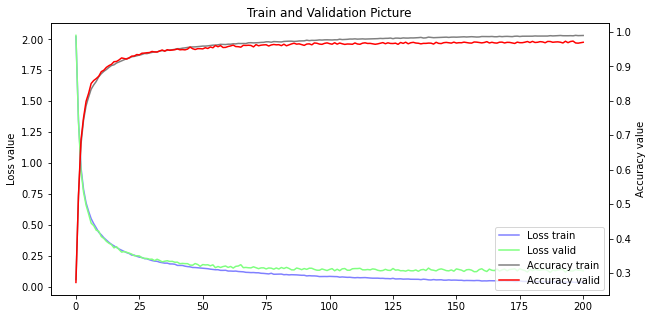

In [21]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
ax1 = fig.add_subplot(111)
ax1.set_title('Train and Validation Picture')
ax1.set_ylabel('Loss value')
line1, = ax1.plot(train_loss_list, color=(0.5, 0.5, 1.0), label='Loss train')
line2, = ax1.plot(val_loss_list, color=(0.5, 1.0, 0.5), label='Loss valid')
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy value')
line3, = ax2.plot(train_acc_list, color=(0.5, 0.5, 0.5), label='Accuracy train')
line4, = ax2.plot(val_acc_list, color=(1, 0, 0), label='Accuracy valid')
plt.legend(handles=(line1, line2, line3, line4), loc='best')
plt.show()

In [22]:
sess.close()

### 恢复模型进行预测
模型仅仅保存着训练出的权重参数，并未定义网络结构，需要定义网络结构，读取模型，在这里由于前面已运行网络结构，这里就不再重新定义

In [23]:
saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

ckpt_dir = './mnist_ckpt'
ckpt = tf.train.get_checkpoint_state(ckpt_dir)

if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)
    print('Restore model from ' + ckpt.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from ./mnist_ckpt\mnist_model_201.ckpt
Restore model from ./mnist_ckpt\mnist_model_201.ckpt


### 准确率不同缘由
因为只保存了模型权重，并未保存网络结构，网络含有 dropout 层，每次读入的权重一样，但网络结构会因为 dropout 层不同，去掉 dropout 层，准确率就会跟前面测试集准确率一样，或者将网络结构一并保存

In [24]:
test_acc = sess.run(accuracy, feed_dict={x:mnist.test.images, y:mnist.test.labels})
print('Test dataset accuracy: %f' % test_acc)

Test dataset accuracy: 0.969300


### 随机可视化显示预测值与标签值

In [25]:
def plot_apply_images(num):
    if num < 1:
        print('INFO:The number of input pictures must be greater than zero!')
    else:
        choose_list = []
        for i in range(num):
            choose_n = np.random.randint(len(mnist.test.images))
            choose_list.append(choose_n)
        fig = plt.gcf()
        fig.set_size_inches(18, 5 * math.ceil(num / 3))
        prediction_result = sess.run(tf.argmax(pred, 1), feed_dict={x:mnist.test.images})
        for i in range(num):
            ax_img = plt.subplot(math.ceil(num / 3), 3, i + 1)
            plt_img = mnist.test.images[choose_list[i]].reshape(28, 28)
            ax_img.imshow(plt_img, cmap='binary')
            ax_img.set_title('Original label:' \
                             + str(np.argmax(mnist.test.labels[choose_list[i]])) \
                             + ' Predict label:' \
                             + str(prediction_result[choose_list[i]]),
                             fontsize=10)
            ax_img.set_xticks([])
            ax_img.set_yticks([])
        plt.show()

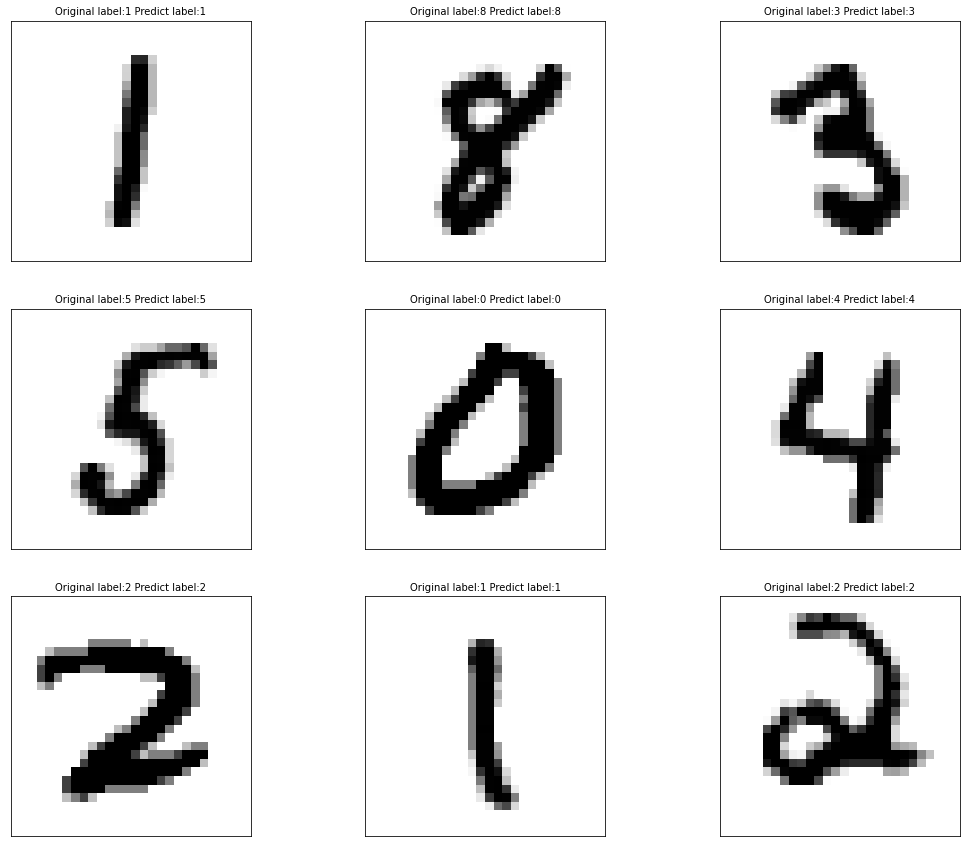

In [26]:
plot_apply_images(9)

### 随机从预测错误中图像

In [48]:
prediction_result = sess.run(tf.argmax(pred, 1), feed_dict={x:mnist.test.images})
predict_bool = (prediction_result == np.argmax(mnist.test.labels, 1))
predict_bool_list = list(predict_bool)
err_list = []
for i in range(len(predict_bool_list)):
    if not predict_bool_list[i]:
        err_list.append(i)
print('There are %d images that are misrecongnized' % len(err_list))

There are 313 images that are misrecongnized


In [54]:
def plot_wrong_images(num):
    prediction_result = sess.run(tf.argmax(pred, 1), feed_dict={x:mnist.test.images})
    predict_bool = (prediction_result == np.argmax(mnist.test.labels, 1))
    predict_bool_list = list(predict_bool)
    err_list = []
    for i in range(len(predict_bool_list)):
        if not predict_bool_list[i]:
            err_list.append(i)
    print('There are %d images that are misrecongnized' % len(err_list))
    if num < 1:
        print('INFO:The number of input pictures must be greater than zero!')
    else:
        choose_list = []
        for i in range(num):
            choose_n = np.random.randint(len(err_list))
            choose_list.append(err_list[choose_n])
        fig = plt.gcf()
        fig.set_size_inches(18, 5 * math.ceil(num / 3))
        for i in range(num):
            ax_img = plt.subplot(math.ceil(num / 3), 3, i + 1)
            plt_img = mnist.test.images[choose_list[i]].reshape(28, 28)
            ax_img.imshow(plt_img, cmap='binary')
            ax_img.set_title('Original label:' \
                             + str(np.argmax(mnist.test.labels[choose_list[i]])) \
                             + ' Predict label:' \
                             + str(prediction_result[choose_list[i]]),
                             fontsize=10)
            ax_img.set_xticks([])
            ax_img.set_yticks([])
        plt.show()

There are 282 images that are misrecongnized


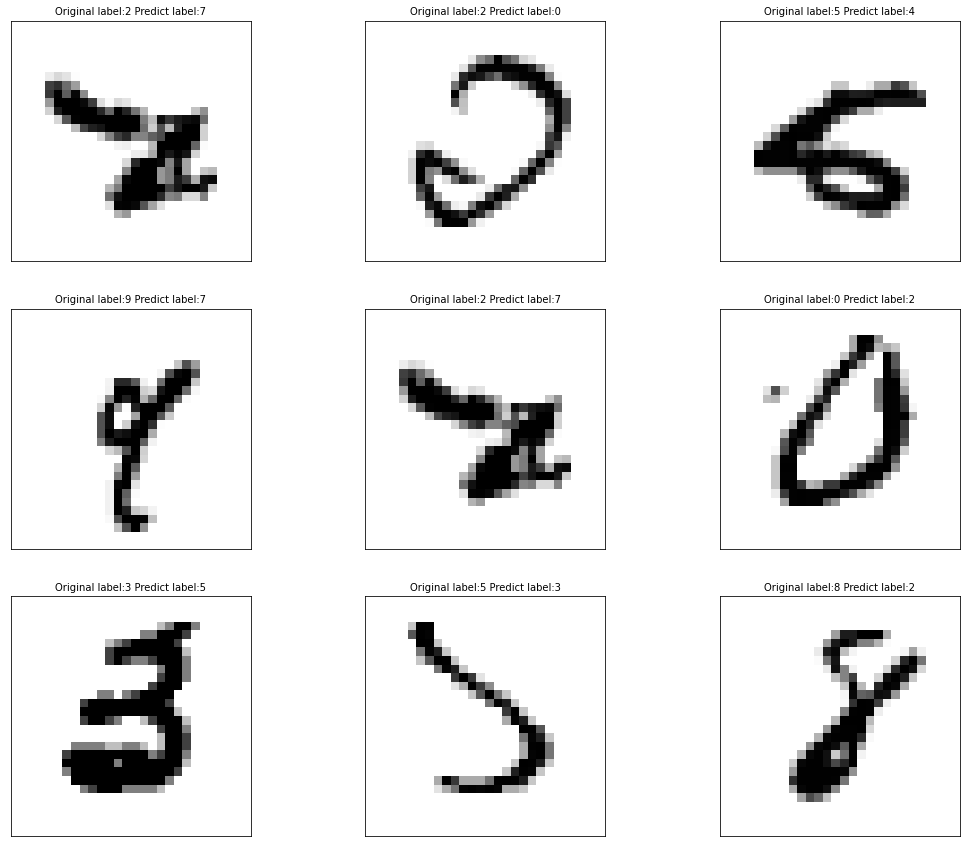

In [55]:
plot_wrong_images(9)